In [1]:
from comet_ml import Experiment

import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"

%load_ext autoreload
%autoreload 3

# eval mode

In [2]:
!nvidia-smi

Tue Feb 11 14:13:51 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.87.01    Driver Version: 418.87.01    CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           On   | 0000666E:00:00.0 Off |                    0 |
| N/A   53C    P0    71W / 149W |   7098MiB / 11441MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  Tesla K80           On   | 0000A3CE:00:00.0 Off |                    0 |
| N/A   57C    P8    28W / 149W |     11MiB / 11441MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  T

In [4]:
import torch
from torch import nn
import torch.nn.functional as F

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm

import seaborn as sns
from IPython.display import clear_output

%matplotlib inline


In [5]:
from rich_utils import data_preprocessing


In [12]:
PARTICLE_TYPE = 'kaon'
MODEL_NAME = "NF_{}_test".format(PARTICLE_TYPE)

BATCH_SIZE = int(1e3)
LATENT_DIMENSIONS = 64

N_VAL = int(3e5)
device = 'cuda' if torch.cuda.is_available() else 'cpu'


## Data

In [6]:
data_train, data_val, scaler = data_preprocessing.get_merged_typed_dataset(PARTICLE_TYPE, dtype=np.float32)

Reading and concatenating datasets:
	../data/data_calibsample/kaon_+_down_2016_.csv
	../data/data_calibsample/kaon_-_up_2016_.csv
	../data/data_calibsample/kaon_+_up_2016_.csv
	../data/data_calibsample/kaon_-_down_2016_.csv
	../data/data_calibsample/kaon2_+_up_2016_.csv
	../data/data_calibsample/kaon2_-_down_2016_.csv
	../data/data_calibsample/kaon2_+_down_2016_.csv
	../data/data_calibsample/kaon2_-_up_2016_.csv
scaler train sample size: 2800000
scaler n_quantiles: 100000, time = 2.4199368953704834
converting dtype to <class 'numpy.float32'>


In [13]:
from rich_utils import data_processing

loader = data_processing.getLoader(data_val, batch_size=BATCH_SIZE, shuffle=False, pin_memory=True)

In [15]:
from pytorch.nflib import flows

SyntaxError: invalid syntax (<ipython-input-15-e45b4ff7f2e0>, line 1)

## Model

In [9]:
CRAMER_DIM = 256
NUM_LAYERS = 5

def get_noise(batch_size, mean=0, std=1):
    return torch.zeros(batch_size, LATENT_DIMENSIONS).normal_(mean, std).to(device)

class Generator(nn.Module):
    def __init__(self, hidden_size=128, depth=5):
        super(Generator, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(LATENT_DIMENSIONS + data_train.shape[1] - 1 - utils_rich.y_count, 128),
            nn.LeakyReLU(0.05),
            *[nn.Sequential(nn.Linear(128, 128), nn.LeakyReLU(0.05)) for _ in range(depth)],
            nn.Linear(128, utils_rich.y_count),
        )

    def forward(self, x, noise=None):
        return self.layers(torch.cat([x, get_noise(x.shape[0])], dim=1))

    
class Critic(nn.Module):
    def __init__(self, hidden_size=128, depth=5):
        super(Critic, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(data_train.shape[1] - 1, 128),
            nn.LeakyReLU(0.05),
            *[nn.Sequential(nn.Linear(128, 128), nn.LeakyReLU(0.05)) for _ in range(depth)],
            nn.Linear(128, CRAMER_DIM),
        )

    def forward(self, x):
        return self.layers(x)

def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)

In [10]:
netG = Generator(depth=NUM_LAYERS).to(device)
netG.apply(init_weights)

netC = Critic(depth=NUM_LAYERS).to(device)
netC.apply(init_weights)

pass

In [11]:
optC = torch.optim.AdamW(netC.parameters())
lr_C = torch.optim.lr_scheduler.ExponentialLR(optimizer=optC, gamma=0.995)
optG = torch.optim.AdamW(netG.parameters())
lr_G = torch.optim.lr_scheduler.ExponentialLR(optimizer=optG, gamma=0.995)

## Train

In [12]:
LOGDIR = "./log"

CRITIC_ITERATIONS_CONST = 15
TOTAL_ITERATIONS = int(5e4)
VALIDATION_INTERVAL = 1000


/home/user/miniconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


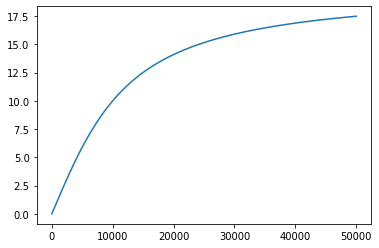

In [13]:
lambda_pt = lambda i: 20 / np.pi * 2 * torch.atan(torch.tensor(i, dtype=torch.float32, device=device)/1e4)

pt = []
for i in tqdm_notebook(range(50000)):
    pt.append(lambda_pt(i))
    
plt.plot(pt)

In [14]:
for i in next(train_loader):
    print(i.shape)

torch.Size([1000, 3])
torch.Size([1000])
torch.Size([1000, 5])


In [15]:
experiment = Experiment(api_key="HIZapbzNjFips0c32Co7gXkQZ",
                        project_name="rich2019", workspace="maximartemev", disabled=False)


COMET WARNING: Failing to collect the installed os packages
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/maximartemev/rich2019/b8c9f174676d42ee933e11c3345a952b



In [16]:
def calc_gradient_penalty(real_data, fake_data, fake_data2):
    alpha = torch.rand(BATCH_SIZE, 1)
    alpha = alpha.expand(real_data.size())
    alpha = alpha.to(device)

    interpolates = alpha * real_data + ((1 - alpha) * fake_data)
    
#     interpolates = torch.Tensor(interpolates, requires_grad=True)

    disc_interpolates = cramer_critic(interpolates, fake_data2)

    gradients = grad(outputs=disc_interpolates, inputs=interpolates,
                     grad_outputs=torch.ones(disc_interpolates.size()).to(device),
                     create_graph=True, retain_graph=True, only_inputs=True)[0]
    # create_graph=True, retain_graph=True, only_inputs=True - crucial for our case

    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
    return gradient_penalty


In [17]:
def cramer_critic(x, y):
    discriminated_x = netC(x)
    return torch.norm(discriminated_x - netC(y), dim=1) - torch.norm(discriminated_x, dim=1)

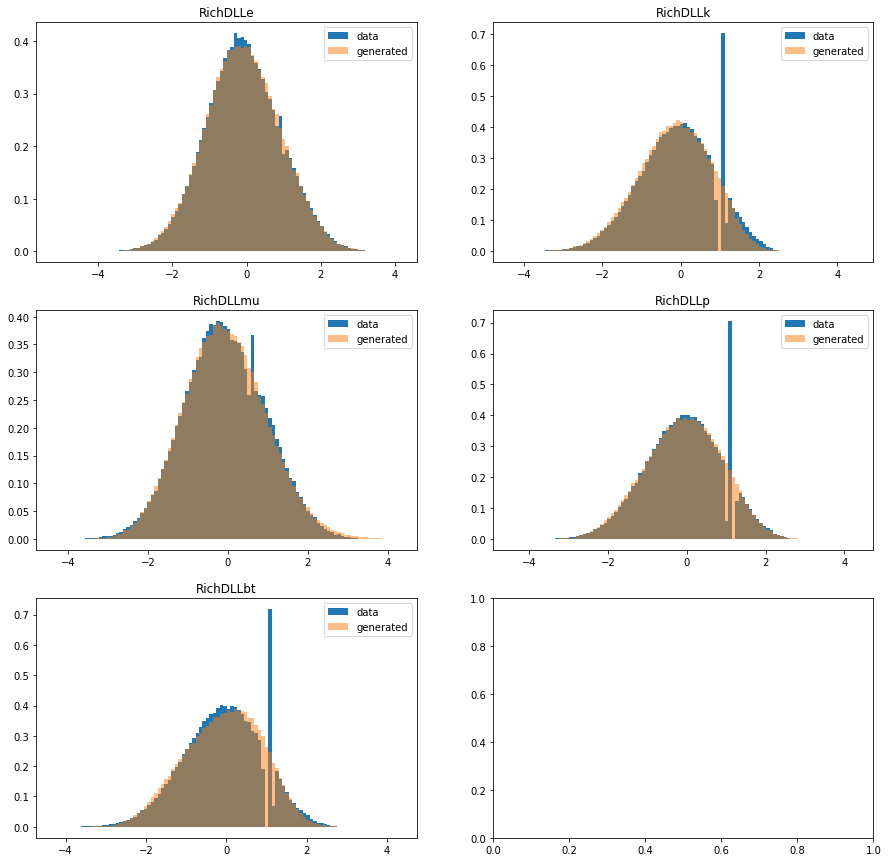

  1%|          | 3183/450000 [31:50<72:05:29,  1.72it/s] 

In [ ]:
for iteration in tqdm(range(TOTAL_ITERATIONS, 10*TOTAL_ITERATIONS), position=0, leave=True):
    for critic_iter in range(CRITIC_ITERATIONS_CONST):
        x, weight, dlls = [i.to(device) for i in next(train_loader)]
        
        optC.zero_grad()
        
        netG.eval()
        netC.train()
        
        real_full_0 = torch.cat([dlls, x], dim=1)    
        generated_1 = torch.cat([netG(x), x], dim=1)
        generated_2 = torch.cat([netG(x), x], dim=1)
        
        generator_loss = torch.mean(cramer_critic(real_full_0, generated_2) * weight - 
                                    cramer_critic(generated_1, generated_2) * weight)
        
        # GP
        gradient_penalty = calc_gradient_penalty(real_full_0, generated_1, generated_2)
        
        critic_loss = lambda_pt(iteration) * gradient_penalty - generator_loss
        critic_loss.backward()
        optC.step()
        
    x, weight, dlls = [i.to(device) for i in next(train_loader)]
    
    netC.eval()
    netG.train()
    
    optG.zero_grad()
    real_full_0 = torch.cat([dlls, x], dim=1)
    generated_1 = torch.cat([netG(x), x], dim=1)
    generated_2 = torch.cat([netG(x), x], dim=1)

    generator_loss = torch.mean(cramer_critic(real_full_0, generated_2) * weight -
                cramer_critic(generated_1, generated_2) * weight)
    
    generator_loss.backward()
    optG.step()
    
    experiment.log_metrics({'Generator loss': generator_loss.item(),
                            'Critic loss': critic_loss.item()},
                            step=iteration)
    lr_C.step()
    lr_G.step()
    
    if iteration % 1000 == 0:
        clear_output(False)
        with torch.no_grad():
            x, weight, dlls = [i.to(device) for i in next(val_loader)]
            real_full = torch.cat([dlls, x], dim=1)

            generated = netG(x)
            fig, axes = plt.subplots(3, 2, figsize=(15, 15))
            for INDEX, ax in zip((0, 1, 2, 3, 4), axes.flatten()):
                _, bins, _ = ax.hist(dlls[:, INDEX].cpu(),
                                     bins=100,
                                     label="data",
                                     normed=True,
                                     weights=weight.cpu())
                ax.hist(generated[:, INDEX].cpu(),
                        bins=bins,
                        label="generated",
                        alpha=0.5,
                        normed=True,
                        weights=weight.cpu())
                ax.legend()
                ax.set_title(utils_rich.dll_columns[INDEX])
            experiment.log_figure()
            plt.show()
experiment.end()

In [23]:
torch.save({MODEL_NAME+'netC_state_dict': netC.state_dict(),
            MODEL_NAME+'netG_state_dict': netG.state_dict(),
            MODEL_NAME+'optC_state_dict': optC.state_dict(),
            MODEL_NAME+'optG_state_dict': optG.state_dict(),
            MODEL_NAME+'lr_C_state_dict': lr_C.state_dict(),
            MODEL_NAME+'lr_G_state_dict': lr_G.state_dict()
           }, LOGDIR)
from sklearn.externals import joblib
os.makedirs('./preprocessors', exist_ok=True)
joblib.dump(scaler, os.path.join('preprocessors', MODEL_NAME) + "_preprocessor.pkl")

/home/user/miniconda/envs/py36/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


['preprocessors/Pytorch_Cramer_pion_5layer_preprocessor.pkl']

/home/user/miniconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  if sys.path[0] == '':
/home/user/miniconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.


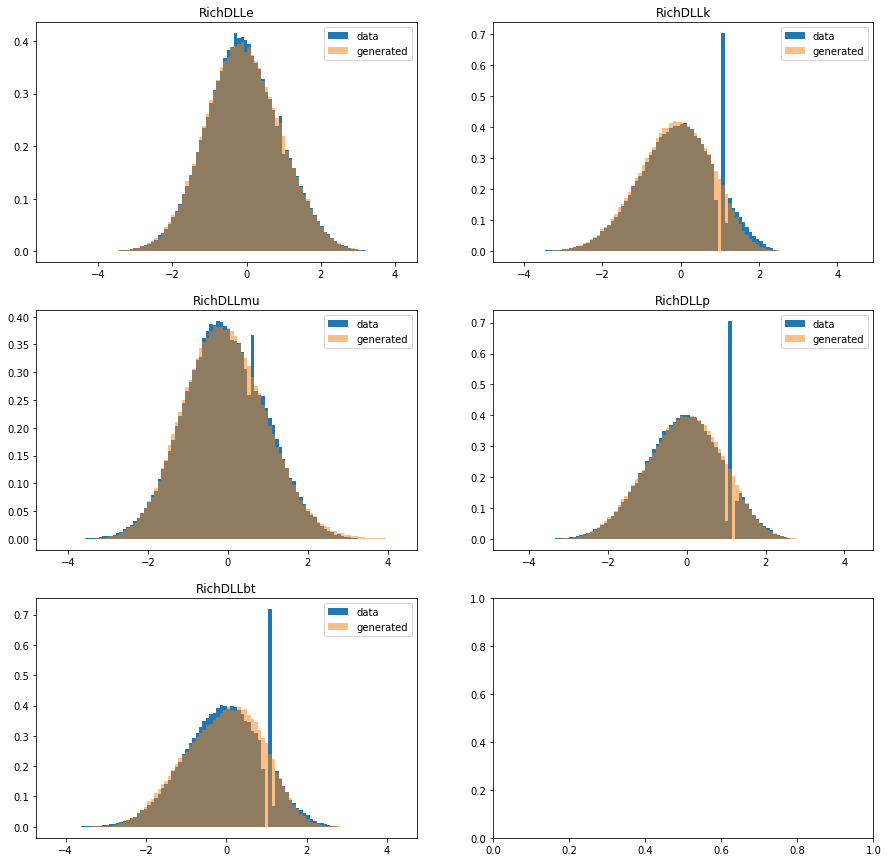

In [20]:
with torch.no_grad():
    x, weight, dlls = [i.to(device) for i in next(val_loader)]
    real_full = torch.cat([dlls, x], dim=1)

    generated = netG(x)
    fig, axes = plt.subplots(3, 2, figsize=(15, 15))
    for INDEX, ax in zip((0, 1, 2, 3, 4), axes.flatten()):
        _, bins, _ = ax.hist(dlls[:, INDEX].cpu(),
                             bins=100,
                             label="data",
                             normed=True,
                             weights=weight.cpu())
        ax.hist(generated[:, INDEX].cpu(),
                bins=bins,
                label="generated",
                alpha=0.5,
                normed=True,
                weights=weight.cpu())
        ax.legend()
        ax.set_title(utils_rich.dll_columns[INDEX])
    experiment.log_figure()
    plt.show()


In [24]:
eval_loader = torch.utils.data.DataLoader(ParticleSet(data_val.values),
                                                      batch_size=N_VAL,
                                                      shuffle=False,
                                                      pin_memory=True)

pred_dlls_ = []
for batch in tqdm(eval_loader, position=0, leave=True):
    x, weight, dlls = [i.to(device) for i in batch]
    pred_dlls_.append(netG(x).detach().cpu().numpy())

100%|██████████| 4/4 [00:19<00:00,  4.86s/it]


In [25]:
pred_dlls = np.concatenate(pred_dlls_, axis=0)
pred_data = np.concatenate([pred_dlls, data_val.values[:, utils_rich.y_count:-1]], axis=1)

pred_data_inversed = scaler.inverse_transform(pred_data)
val_data_inversed = scaler.inverse_transform(data_val.iloc[:, :-1])


In [26]:
val_data_inversed_ = pd.DataFrame(val_data_inversed,
                                  columns=data_val.columns[:-1])
for ind, col in enumerate(utils_rich.dll_columns):
    val_data_inversed_["predicted_"+col] = pred_data_inversed[:, ind]
val_data_inversed_['probe_sWeight'] = data_val['probe_sWeight']

In [27]:
class Wrapper:
    def __init__(self, data):
        self.test = data

wrap = lambda x, particle: {particle: Wrapper(x)}

In [28]:
from rich_utils.model_testing import eval_model

scores, bins = eval_model(PARTICLE_TYPE, wrap(val_data_inversed_, PARTICLE_TYPE))

  0%|          | 0/3 [00:00<?, ?it/s]/home/user/miniconda/envs/py36/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")
100%|██████████| 3/3 [02:43<00:00, 54.36s/it]


In [29]:
print("Particle: {}, global test score: {} +- {}".format(PARTICLE_TYPE,
                                                         scores.mean(axis=0)[0][1],
                                                         scores.std(axis=0)[0][1]))

Particle: pion, global test score: 0.9432537254448752 +- 0.002039680284385014
